In [2]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import splitfolders

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

In [ ]:
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.preprocessing import image_dataset_from_directory

# for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Split the folders into train - 80%, test- 10% and validation sets-10%.

In [8]:
splitfolders.ratio(r"C:\Users\Victor Umunna\projects\AI-Hacktober-MLSA\Project_1\Data", 
                   output=r"C:\Users\Victor Umunna\projects\AI-Hacktober-MLSA\Project_1\Output_Data",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [ ]:
train_path = '/content/AI-Hacktober-MLSA/Project_1/Output_Data/train'
val_path = '/content/AI-Hacktober-MLSA/Project_1/Output_Data/val'
test_path = '/content/AI-Hacktober-MLSA/Project_1/Output_Data/test'

In [ ]:
# generate train, test and validation sets from directory

train_ds = image_dataset_from_directory(train_path, label_mode = 'categorical',
                                        image_size = (528, 528))
val_ds = image_dataset_from_directory(val_path, label_mode = 'categorical',
                                      image_size = (528, 528))
test_ds = image_dataset_from_directory(test_path, label_mode = 'categorical',
                                       shuffle= False, image_size = (528, 528))

Found 180 files belonging to 3 classes.
Found 22 files belonging to 3 classes.
Found 24 files belonging to 3 classes.


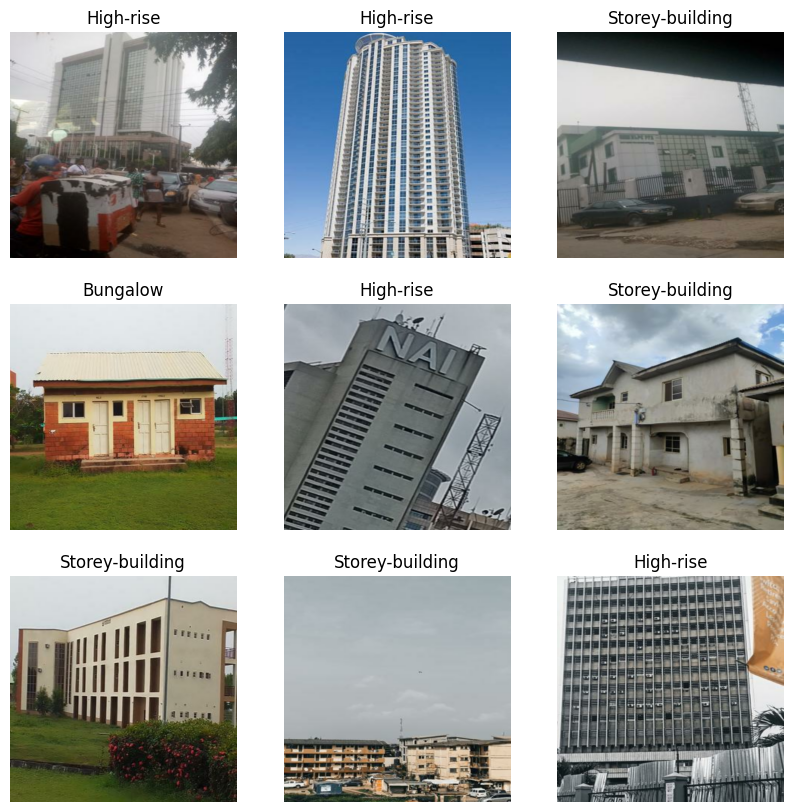

In [ ]:
# View dataset

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

Visualize the first data and try to predit it

(-0.5, 527.5, 527.5, -0.5)

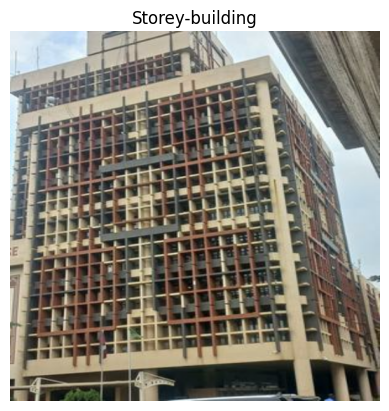

In [ ]:
for images, label in train_ds.take(1):
  first_image = images[0]

plt.imshow(first_image.numpy().astype("uint8"))
plt.title(class_names[np.argmax(label[i], axis=None, out=None)])
plt.axis('off')

We are using the EfficientNetB6 classification model.

In [ ]:
# make predictions using a pretrained model

from keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.preprocessing import image

x = image.img_to_array(first_image)
x = np.expand_dims(x, axis=0)

base_model = EfficientNetB6(weights='imagenet')
pred = base_model.predict(x)
print('Predicted:', decode_predictions(pred))

35363/35363 [==============================] - 0s 0us/step
Predicted: [[('n03661043', 'library', 0.29960614), ('n03877845', 'palace', 0.13826913), ('n02825657', 'bell_cote', 0.047719683), ('n03126707', 'crane', 0.04522186), ('n02782093', 'balloon', 0.021736445)]]


Create a base model using the EfficientNetB6 model.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = EfficientNetB6(weights='imagenet', include_top=False,
                            input_shape=(528, 528,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

165234480/165234480 [==============================] - 1s 0us/step


In [ ]:
# create callbacks fr training
my_callbacks = tf.keras.callbacks.ModelCheckpoint('weights.h5', save_best_only = True,
                                                  save_weights_only = True)

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[my_callbacks])

Epoch 1/10
6/6 [==============================] - 529s 86s/step - loss: 0.9469 - accuracy: 0.5667 - val_loss: 0.7381 - val_accuracy: 0.7273
Epoch 2/10
6/6 [==============================] - 519s 88s/step - loss: 0.6811 - accuracy: 0.7444 - val_loss: 0.6107 - val_accuracy: 0.7273
Epoch 3/10
6/6 [==============================] - 504s 86s/step - loss: 0.5438 - accuracy: 0.7833 - val_loss: 0.5377 - val_accuracy: 0.7727
Epoch 4/10
6/6 [==============================] - 513s 87s/step - loss: 0.4651 - accuracy: 0.8611 - val_loss: 0.4822 - val_accuracy: 0.8182
Epoch 5/10
6/6 [==============================] - 482s 79s/step - loss: 0.3966 - accuracy: 0.8722 - val_loss: 0.4512 - val_accuracy: 0.8182
Epoch 6/10
6/6 [==============================] - 516s 88s/step - loss: 0.3461 - accuracy: 0.9000 - val_loss: 0.4284 - val_accuracy: 0.9091
Epoch 7/10
6/6 [==============================] - 519s 89s/step - loss: 0.2989 - accuracy: 0.9167 - val_loss: 0.4115 - val_accuracy: 0.8636
Epoch 8/10
6/6 [====

In [ ]:
results = history.history

<ipython-input-19-a6c73883fee0>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


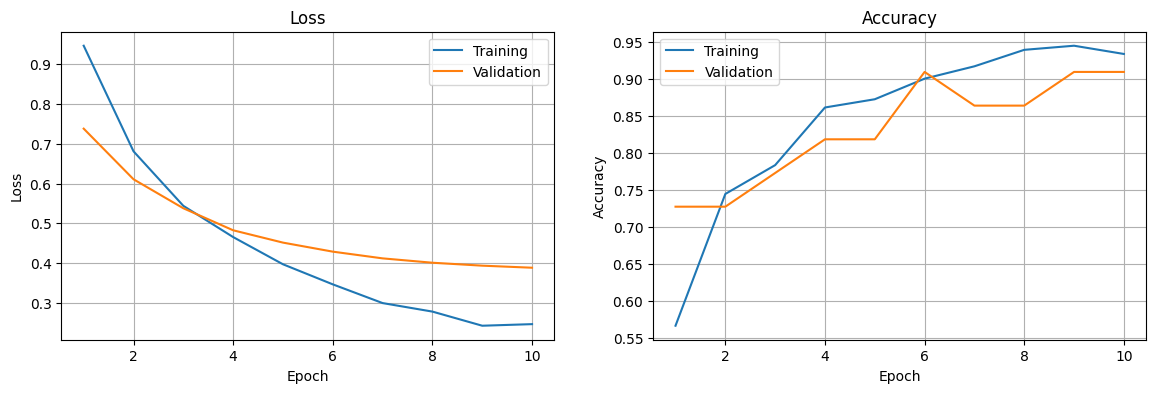

In [ ]:
# plot results

n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.load_weights('weights.h5')

Predit the test dataset

In [ ]:
predictions = model.evaluate(test_ds)

1/1 [==============================] - 55s 55s/step - loss: 0.1169 - accuracy: 1.0000


In [ ]:
predictions = model.predict(test_ds)
predictions

1/1 [==============================] - 69s 69s/step


array([[8.2526720e-01, 2.2513198e-03, 1.7248152e-01],
       [7.4613059e-01, 9.6720150e-03, 2.4419729e-01],
       [9.5178944e-01, 1.2478379e-03, 4.6962693e-02],
       [6.8842453e-01, 1.3243837e-02, 2.9833162e-01],
       [7.7034241e-01, 2.0008534e-02, 2.0964909e-01],
       [2.1714952e-03, 9.4411051e-01, 5.3717975e-02],
       [1.1326050e-03, 9.8861939e-01, 1.0248011e-02],
       [2.3599571e-04, 9.9198806e-01, 7.7758958e-03],
       [9.2682289e-04, 9.9290550e-01, 6.1677126e-03],
       [2.3175457e-04, 9.9584341e-01, 3.9247391e-03],
       [3.2024612e-04, 9.9327487e-01, 6.4048436e-03],
       [2.7312405e-04, 9.9006188e-01, 9.6649826e-03],
       [1.0316588e-03, 9.9257904e-01, 6.3892212e-03],
       [5.4892823e-02, 3.8331009e-02, 9.0677613e-01],
       [9.0665162e-02, 1.3915946e-01, 7.7017540e-01],
       [4.8232980e-02, 7.7507213e-02, 8.7425977e-01],
       [1.5861528e-02, 1.6507361e-02, 9.6763104e-01],
       [3.1122869e-02, 2.0074425e-02, 9.4880277e-01],
       [1.2657459e-02, 2.265

In [ ]:
# save the index of the highest probability
predictions = predictions.argmax(axis=1)
predictions

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [ ]:
# get the actual values

test_images = list(test_ds.unbatch().as_numpy_iterator())
y_true = np.array([i[1] for i in test_images])
y_true = y_true.argmax(axis=1)
y_true

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [ ]:
# calculate f1_score
from sklearn.metrics import f1_score
f1_score(y_true,predictions,average='macro')

1.0

We got an F1_score of 1.

In [ ]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,predictions)

array([[ 5,  0,  0],
       [ 0,  8,  0],
       [ 0,  0, 11]])

This looks like a perfect model with perfect *accuracy*

In [ ]:
 # Save the model as .pkl

import pickle
pickle.dump(model, open('EfficientNetB6_1.0.pkl', 'wb'))